In [1]:
import warnings
from pathlib import Path
import os
import pandas as pd
import tqdm
import random
import pickle

import socceraction.spadl as spadl
import socceraction.atomic.spadl as atomicspadl
import socceraction.atomic.vaep.features as fs
import socceraction.atomic.vaep.labels as lab
import socceraction.atomic.vaep.formula as vaepformula
from socceraction.spadl.wyscout import convert_to_actions
from socceraction.data.wyscout import PublicWyscoutLoader

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as logistic
from sklearn.ensemble import RandomForestClassifier as rfc
from catboost import CatBoostClassifier 
from xgboost import XGBClassifier as XGBc
from sklearn.metrics import brier_score_loss, roc_auc_score, log_loss

# Preprocessing

In [2]:
wyscout = PublicWyscoutLoader(root = '/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/data', download=False)

In [3]:
competitions = wyscout.competitions()
competitions.info()

<class 'pandera.typing.pandas.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   competition_id      7 non-null      int64 
 1   season_id           7 non-null      int64 
 2   country_name        7 non-null      object
 3   competition_name    7 non-null      object
 4   competition_gender  7 non-null      object
 5   season_name         7 non-null      object
dtypes: int64(2), object(4)
memory usage: 464.0+ bytes


In [4]:
comp = ['England']
selected_competitions = competitions[(competitions['country_name'] =='England')]
selected_competitions

,competition_id,season_id,country_name,competition_name,competition_gender,season_name
1,364,181150,England,English first division,male,2017/2018


### Retrieve the scoreline of a game

In [5]:
dfs_matches = []
#Retrieve matches of a selected competition
for competition in comp:
    competition_name = competition
    file_matches = f'matches_{competition_name}.json'
    df_matches = pd.read_json('/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/Data/' + file_matches)
    dfs_matches.append(df_matches)
    
#Create a unique dataframe containing all the selected games
df_matches = pd.concat(dfs_matches)
df_matches.reset_index(drop = True, inplace = True)
df_matches.head(1)

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,referees,duration,competitionId
0,Played,4405654,38,"{'1646': {'scoreET': 0, 'coachId': 8880, 'side...",181150,2018-05-13 14:00:00,1659,Turf Moor,2500089,"Burnley - AFC Bournemouth, 1 - 2","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 385705, 'role': 'referee'}, {'r...",Regular,364


In [6]:
#Extrapolate the scoreline of the game 
home_score, away_score = [],[]
for i in range(len(df_matches)) : 
    home_id, away_id = df_matches['teamsData'][i].keys()
    if df_matches['teamsData'][i][home_id]['side'] == 'away':
        home_id, away_id = away_id, home_id
    if df_matches['duration'][i] !='Regular':
        home_score.append(df_matches['teamsData'][i][home_id]['scoreET'])
        away_score.append(df_matches['teamsData'][i][away_id]['scoreET'])
    else:    
        home_score.append(df_matches['teamsData'][i][home_id]['score']+df_matches['teamsData'][i][home_id]['scoreET'])
        away_score.append(df_matches['teamsData'][i][away_id]['score']+df_matches['teamsData'][i][away_id]['scoreET'])

df_matches['home_score'] = home_score
df_matches['away_score'] = away_score
df_matches = df_matches[['seasonId','wyId','label','competitionId', 'home_score','away_score']]
df_matches.rename(columns={'seasonId':'season_id', 'wyId':'game_id','competitionId':'competition_id'}, inplace = True)

df_matches.head()

,season_id,game_id,label,competition_id,home_score,away_score
0,181150,2500089,"Burnley - AFC Bournemouth, 1 - 2",364,1,2
1,181150,2500090,"Crystal Palace - West Bromwich Albion, 2 - 0",364,2,0
2,181150,2500091,"Huddersfield Town - Arsenal, 0 - 1",364,0,1
3,181150,2500092,"Liverpool - Brighton & Hove Albion, 4 - 0",364,4,0
4,181150,2500093,"Manchester United - Watford, 1 - 0",364,1,0


In [7]:
# Get games  with goals from all selected competitions
games = pd.concat([wyscout.games(row.competition_id, row.season_id) for row in selected_competitions.itertuples()])

match_goals = pd.merge(games, df_matches, on =['game_id','competition_id','season_id'])
match_goals.drop(['label'],axis = 1, inplace = True)
games = match_goals

games.head()

,game_id,competition_id,season_id,game_date,game_day,home_team_id,away_team_id,home_score,away_score
0,2500089,364,181150,2018-05-13 14:00:00,38,1646,1659,1,2
1,2500090,364,181150,2018-05-13 14:00:00,38,1628,1627,2,0
2,2500091,364,181150,2018-05-13 14:00:00,38,1673,1609,0,1
3,2500092,364,181150,2018-05-13 14:00:00,38,1612,1651,4,0
4,2500093,364,181150,2018-05-13 14:00:00,38,1611,1644,1,0


In [8]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380 entries, 0 to 379
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   game_id         380 non-null    int64         
 1   competition_id  380 non-null    int64         
 2   season_id       380 non-null    int64         
 3   game_date       380 non-null    datetime64[ns]
 4   game_day        380 non-null    int64         
 5   home_team_id    380 non-null    int64         
 6   away_team_id    380 non-null    int64         
 7   home_score      380 non-null    int64         
 8   away_score      380 non-null    int64         
dtypes: datetime64[ns](1), int64(8)
memory usage: 29.7 KB


# SPADL

In [10]:
#Store everything in the HDF
datafolder = "/Users/leonardoyang/Desktop/data-fifa/Eng"

In [11]:
#To upload the DF
spadl_h5 = os.path.join(datafolder, "atomic_spadl-wyscout.h5")

In [12]:
pd.HDFStore(spadl_h5)['teams'].reset_index().drop('index', axis =1)

,team_id,team_name_short,team_name
0,1646,Burnley,Burnley FC
1,1659,AFC Bournemouth,AFC Bournemouth
2,1628,Crystal Palace,Crystal Palace FC
3,1627,West Bromwich Albion,West Bromwich Albion FC
4,1609,Arsenal,Arsenal FC
5,1673,Huddersfield Town,Huddersfield Town FC
6,1651,Brighton & Hove Albion,Brighton & Hove Albion FC
7,1612,Liverpool,Liverpool FC
8,1644,Watford,Watford FC
9,1611,Manchester United,Manchester United FC


In [13]:
#Select a game
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    # Select Brighton vs Liverpool
    game = games[(games.country_name == "England") 
                  & (games.home_team_name_short == "Brighton & Hove Albion")
                  & (games.away_team_name_short== "Liverpool")]
    game_id = game.game_id.values[0]
    atomic_actions = spadlstore[f"actions/game_{game_id}"]
    atomic_actions = (
        atomic_actions
        .merge(atomicspadl.actiontypes_df(), how="left")
        .merge(spadl.bodyparts_df(), how="left")
        .merge(spadlstore["players"], how="left")
        .merge(spadlstore["teams"], how="left")
    )

# use nickname if available else use full name
atomic_actions["player_name"] = atomic_actions[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
del atomic_actions['nickname']
atomic_actions[594:599]

,game_id,original_event_id,action_id,period_id,time_seconds,team_id,player_id,x,y,dx,dy,type_id,bodypart_id,type_name,bodypart_name,player_name,team_name_short,team_name
594,2499861,211308776,594,1,1152.648785,1612,120353,14.7,38.76,6.3,-17.68,0,0,pass,foot,Mohamed Salah,Liverpool,Liverpool FC
595,2499861,211308776,595,1,1153.605692,1612,3802,21.0,21.08,0.0,0.00,23,0,receival,foot,Philippe Coutinho,Liverpool,Liverpool FC
596,2499861,211308777,596,1,1154.562600,1612,3802,21.0,21.08,-14.7,-8.84,0,0,pass,foot,Philippe Coutinho,Liverpool,Liverpool FC
597,2499861,211308777,597,1,1156.022010,1612,222220,6.3,12.24,0.0,0.00,23,0,receival,foot,A. Robertson,Liverpool,Liverpool FC
598,2499861,211308778,598,1,1157.481420,1612,222220,6.3,12.24,-2.1,34.68,1,0,cross,foot,A. Robertson,Liverpool,Liverpool FC


In [14]:
#Example for pdf
games[games.game_id ==2499861].drop(['season_id','country_name','competition_gender','home_team_name_short','away_team_name_short','season_name'], axis = 1).reset_index(drop = True)

,game_id,competition_id,game_date,game_day,home_team_id,away_team_id,home_score,away_score,competition_name,home_team_name,away_team_name
0,2499861,364,2017-12-02 15:00:00,15,1651,1612,1,5,English first division,Brighton & Hove Albion FC,Liverpool FC


2017-12-02 15:00:00, Brighton & Hove Albion FC - Liverpool FC : 1-5 , Roberto Firmino 48'


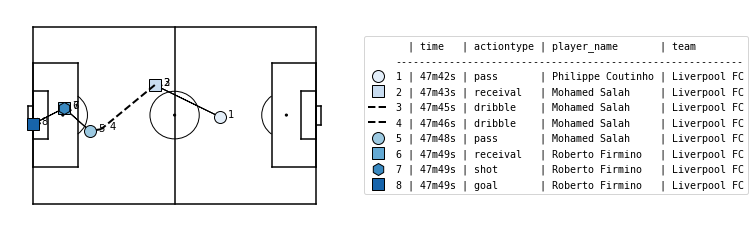

In [15]:
#select a goal to plot
import matplotsoccer

for shot in list(atomic_actions[(atomic_actions.type_name == "goal")][2:3].index):
    a = atomic_actions[shot-7:shot+1].copy()

    a["start_x"] = a.x
    a["start_y"] = a.y
    a["end_x"] = a.x + a.dx
    a["end_y"] = a.y + a.dy

    g = game.iloc[0]
    minute = int((a.period_id.values[0] - 1) * 45 + a.time_seconds.values[0] // 60)
    game_info = f"{g.game_date}, {g.home_team_name} - {g.away_team_name} : {g.home_score}-{g.away_score} , {a[-1:].player_name.values[0]} {minute + 1}'"
    print(game_info)

    def nice_time(row):
        minute = int((row.period_id-1) * 45 + row.time_seconds // 60)
        second = int(row.time_seconds % 60)
        return f"{minute}m{second}s"

    a["nice_time"] = a.apply(nice_time,axis=1)
    labels = a[["nice_time", "type_name", "player_name", "team_name"]]

    matplotsoccer.actions(
        location=a[["start_x", "start_y", "end_x", "end_y"]],
        action_type=a.type_name,
        team= a.team_name,
        label=labels,
        labeltitle=["time", "actiontype", "player_name", "team"],
        zoom=False,
        figsize=6
    )

## Compute features and labels

In [16]:
features_h5 = os.path.join(datafolder, "atomic_features.h5")
labels_h5 = os.path.join(datafolder, "atomic_labels.h5")

In [17]:
games = pd.HDFStore(spadl_h5)['games']
print("nb of games:", len(games))

nb of games: 380


In [18]:
#Example of final framework
print('Features')
display( pd.HDFStore(features_h5)["game_2499861"].head()) #With lags -1,-2.
print('Labels')
display(pd.HDFStore(labels_h5)["game_2499861"].head())

Features


,type_id_a0,type_id_a1,type_id_a2,type_pass_a0,type_cross_a0,type_throw_in_a0,type_freekick_crossed_a0,type_freekick_short_a0,type_corner_crossed_a0,type_corner_short_a0,...,time_seconds_a0,time_seconds_overall_a0,period_id_a1,time_seconds_a1,time_seconds_overall_a1,period_id_a2,time_seconds_a2,time_seconds_overall_a2,time_delta_1,time_delta_2
0,0,0,0,True,False,False,False,False,False,False,...,4.107425,4.107425,1,4.107425,4.107425,1,4.107425,4.107425,0.000000,0.000000
1,23,0,0,False,False,False,False,False,False,False,...,5.166622,5.166622,1,4.107425,4.107425,1,4.107425,4.107425,1.059197,1.059197
2,0,23,0,True,False,False,False,False,False,False,...,6.225819,6.225819,1,5.166622,5.166622,1,4.107425,4.107425,1.059197,2.118394
3,23,0,23,False,False,False,False,False,False,False,...,7.954884,7.954884,1,6.225819,6.225819,1,5.166622,5.166622,1.729065,2.788263
4,0,23,0,True,False,False,False,False,False,False,...,9.683950,9.683950,1,7.954884,7.954884,1,6.225819,6.225819,1.729065,3.458131


Labels


,scores,concedes,goal
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False


### Predictions

In [19]:
predictions_h5 = os.path.join(datafolder, "atomic-predictions-one-action.h5")

In [20]:
# 1. Select feature set X
xfns = [
    fs.actiontype_onehot,
    fs.bodypart_onehot,
    fs.goalscore,
    fs.location,
    fs.movement_polar,
    fs.polar,
    fs.direction,
    fs.team,
    fs.time,
    fs.time_delta
]
nb_prev_actions = 3

Xcols = fs.feature_column_names(xfns, nb_prev_actions)

def getXY(games, Xcols):
    # generate the columns of the selected feature
    X = []
    for game_id in tqdm.tqdm(games.game_id, desc="Selecting features"):
        Xi = pd.HDFStore(features_h5) [f"game_{game_id}"]
        X.append(Xi[Xcols])
    X = pd.concat(X).reset_index(drop=True)

    # 2. Select label Y
    Ycols = ["scores", "concedes"]
    Y = []
    for game_id in tqdm.tqdm(games.game_id, desc="Selecting label"):
        Yi = pd.HDFStore(labels_h5)[f"game_{game_id}"]
        Y.append(Yi[Ycols])
    Y = pd.concat(Y).reset_index(drop=True)
    return X, Y

In [21]:
### load model 
model = pickle.load(open('trained_model.sav', 'rb'))

In [22]:
#Prediction for all games
gamesX, gamesY = getXY(games,Xcols)
Y_hat = pd.DataFrame()
for col in gamesY.columns:
    Y_hat[col] = [p[1] for p in model[col].predict_proba(gamesX)]

Selecting label: 100%|██████████| 380/380 [00:03<00:00, 99.40it/s] 


In [23]:
# get rows with game id per action
A = []
for game_id in tqdm.tqdm(games.game_id, "Loading actions of each game"):
    Ai = pd.HDFStore(spadl_h5) [f"actions/game_{game_id}"]
    A.append(Ai[["game_id"]])
A = pd.concat(A)
A = A.reset_index(drop=True)

# concatenate action game id rows with predictions and save per game
grouped_predictions = pd.concat([A, Y_hat], axis=1).groupby("game_id")
for k,df in tqdm.tqdm(grouped_predictions, desc="Saving predictions per game"):
    df = df.reset_index(drop=True)
    df[Y_hat.columns].to_hdf(predictions_h5, f"game_{int(k)}")

Saving predictions per game: 100%|██████████| 380/380 [00:09<00:00, 41.87it/s]


## VAEP

In [24]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    players = spadlstore["players"]
    teams = spadlstore["teams"]
print("nb of games:", len(games))

nb of games: 380


In [25]:
A = []
for game in tqdm.tqdm(list(games.itertuples()), desc="Loading actions"):
    actions = pd.HDFStore(spadl_h5) [f"actions/game_{game.game_id}"]
    actions = (
        atomicspadl.add_names(actions)
        .merge(players, how="left")
        .merge(teams, how="left",)
        .sort_values(["game_id", "period_id", "action_id"])
        .reset_index(drop=True)
    )
    preds = pd.HDFStore(predictions_h5) [f"game_{game.game_id}"]
    values = vaepformula.value(actions, preds.scores, preds.concedes)
    A.append(pd.concat([actions, preds, values], axis=1))
A = pd.concat(A).sort_values(["game_id", "period_id", "time_seconds"]).reset_index(drop=True)
A.columns

Loading actions: 100%|██████████| 380/380 [00:27<00:00, 13.64it/s]


Index(['game_id', 'original_event_id', 'action_id', 'period_id',
       'time_seconds', 'team_id', 'player_id', 'x', 'y', 'dx', 'dy', 'type_id',
       'bodypart_id', 'type_name', 'bodypart_name', 'player_name', 'nickname',
       'team_name_short', 'team_name', 'scores', 'concedes', 'offensive_value',
       'defensive_value', 'vaep_value'],
      dtype='object')

In [26]:
#Retrieve roles for each player
df_players = pd.read_json('/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/players.json')
df_players = df_players[['wyId','shortName','role','currentTeamId']]
Role = []
for i in range(len(df_players)):
    Role.append(df_players['role'][i]['name'])

df_players['Role'] = Role
df_players.drop('role', axis = 1,inplace = True)

In [27]:
A["count"] = 1

# Compute each player's number of actions and total VAEP values
playersR = (
    A[["player_id","vaep_value", "offensive_value", "defensive_value", "count"]]
    .groupby(["player_id"])
    .sum()
    .reset_index()
)
#Add the last team for which the player has played
playersR = playersR.merge(A[["player_id","team_name_short"]].groupby('player_id').tail(1), on = 'player_id')
# Add player name
playersR = playersR.merge(players[["player_id", "nickname", "player_name"]], how="left")
playersR = pd.merge(playersR, df_players, left_on ='player_id', right_on = 'wyId', how = 'left').drop(['wyId','shortName'], axis = 1)
playersR["player_name"] = playersR[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
# Show results
playersR = playersR[["player_id", "player_name","Role", "team_name_short","vaep_value", "offensive_value", "defensive_value", "count"]]
playersR.sort_values("vaep_value", ascending=False)[:10]

,player_id,player_name,Role,team_name_short,vaep_value,offensive_value,defensive_value,count
392,120353,Mohamed Salah,Forward,Liverpool,38.074385,37.383939,0.690446,2836
185,8717,H. Kane,Forward,Tottenham Hotspur,35.214978,34.535301,0.679678,2128
340,61390,M. Ryan,Goalkeeper,Brighton & Hove Albion,29.807561,2.661488,27.146073,1996
71,7905,R. Lukaku,Forward,Manchester United,26.053293,25.681763,0.371531,1828
143,8325,S. Agüero,Forward,Manchester City,25.663223,25.472139,0.191084,1780
4,54,C. Eriksen,Midfielder,Tottenham Hotspur,24.698155,21.841608,2.856547,5416
244,12829,J. Vardy,Forward,Leicester City,23.401707,23.367064,0.034644,1420
237,11066,R. Sterling,Forward,Manchester City,23.392714,22.969587,0.423126,3134
325,38021,K. De Bruyne,Midfielder,Manchester City,23.366588,21.408197,1.958392,6545
108,8094,J. Butland,Goalkeeper,Stoke City,23.265653,3.056390,20.209263,2170


In [28]:
# Normalize for minutes played
pg = pd.HDFStore(spadl_h5) ["player_games"]
pg = pg[pg.game_id.isin(games.game_id)]
mp = pg[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

stats = playersR.merge(mp)
stats.rename(columns={'team_name_short':'Team'}, inplace = True)
stats["vaep_rating"] = stats.vaep_value * 90 / stats.minutes_played
stats["offensive_rating"] = stats.offensive_value * 90 / stats.minutes_played
stats["defensive_rating"] = stats.defensive_value * 90 / stats.minutes_played

In [31]:
#Save and load results
#filename = 'players_eng.sav'
#pickle.dump(stats, open(filename, 'wb'))
stats = pickle.load(open('players_eng.sav', 'rb'))

In [33]:
stats = stats[stats.minutes_played > 1710] # at least 19 full games played
stats.sort_values("vaep_rating",ascending=False)[:10]

,player_id,player_name,Role,Team,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
391,120353,Mohamed Salah,Forward,Liverpool,38.074385,37.383939,0.690446,2836,3065,1.118008,1.097734,0.020274
142,8325,S. Agüero,Forward,Manchester City,25.663223,25.472139,0.191084,1780,2096,1.101951,1.093746,0.008205
184,8717,H. Kane,Forward,Tottenham Hotspur,35.214978,34.535301,0.679678,2128,3257,0.973088,0.954307,0.018781
469,340386,Gabriel Jesus,Forward,Manchester City,17.846282,17.784943,0.061339,1455,1774,0.905392,0.902280,0.003112
257,14911,Son Heung-Min,Forward,Tottenham Hotspur,20.847098,20.129217,0.717880,2550,2424,0.774026,0.747372,0.026654
288,25413,A. Lacazette,Forward,Arsenal,20.021740,19.759096,0.262644,1763,2331,0.773040,0.762899,0.010141
70,7905,R. Lukaku,Forward,Manchester United,26.053293,25.681763,0.371531,1828,3055,0.767527,0.756582,0.010945
26,3319,M. Özil,Midfielder,Arsenal,19.559379,18.277414,1.281965,4213,2295,0.767034,0.716761,0.050273
236,11066,R. Sterling,Forward,Manchester City,23.392714,22.969587,0.423126,3134,2751,0.765301,0.751459,0.013843
248,14703,M. Arnautović,Forward,West Ham United,20.639558,18.293938,2.345620,2168,2464,0.753880,0.668204,0.085676


In [34]:
stats[stats.Role == "Forward"].sort_values('vaep_rating', ascending = False)[:10].reset_index(drop = True)[['player_name','Role','Team','vaep_rating']]

,player_name,Role,Team,vaep_rating
0,Mohamed Salah,Forward,Liverpool,1.118008
1,S. Agüero,Forward,Manchester City,1.101951
2,H. Kane,Forward,Tottenham Hotspur,0.973088
3,Gabriel Jesus,Forward,Manchester City,0.905392
4,Son Heung-Min,Forward,Tottenham Hotspur,0.774026
5,A. Lacazette,Forward,Arsenal,0.773040
6,R. Lukaku,Forward,Manchester United,0.767527
7,R. Sterling,Forward,Manchester City,0.765301
8,M. Arnautović,Forward,West Ham United,0.753880
9,E. Hazard,Forward,Chelsea,0.719505


In [35]:
stats[stats.Role == "Defender"].sort_values('vaep_rating', ascending = False)[:10].reset_index(drop = True)[['player_name','Role','Team','vaep_rating']]

,player_name,Role,Team,vaep_rating
0,P. van Aanholt,Defender,Crystal Palace,0.597751
1,L. Koscielny,Defender,Arsenal,0.434906
2,Nacho Monreal,Defender,Arsenal,0.415888
3,Marcos Alonso,Defender,Chelsea,0.393314
4,D. Janmaat,Defender,Watford,0.368733
5,J. Matip,Defender,Liverpool,0.360493
6,A. Valencia,Defender,Manchester United,0.359792
7,J. Stephens,Defender,Southampton,0.344522
8,A. Robertson,Defender,Liverpool,0.337302
9,J. Tomkins,Defender,Crystal Palace,0.335416


# Salary

In [36]:
#Upload salaries
eng = pd.read_excel('/Users/leonardoyang/Desktop/Tesi/Data/premier-league/2017-2018/all_premier-league_2017-2018.xlsx')
eng["Annual Gross(IN EUR)"] = eng["Annual Gross(IN GBP)"]*1.14
eng = eng[eng["Annual Gross(IN EUR)"]>0]
eng = eng.drop_duplicates(subset=["Player"], keep='last')
eng.drop('Unnamed: 0', axis = 1, inplace = True)
eng['Name'] = [eng['Player'][i-1:i].values[0].split()[0] for i in range(1,len(eng.Player)+1)]
eng['Surname'] = [eng['Player'][i-1:i].values[0].split()[-1] for i in range(1,len(eng.Player)+1)]

In [42]:
#Retrieve player full name and surname
players['Name'] =[players['player_name'][i-1:i].values[0].split()[0] for i in range(1,len(players.player_name)+1)]
players['Surname'] =[players['player_name'][i-1:i].values[0].split()[-1] for i in range(1,len(players.player_name)+1)]
giocatori = stats.merge(players, on = 'player_id').drop(['nickname'], axis = 1)

#Merge players' stats and salary based on surname,name. Those players not matched due to language barriers were manually added by including their WyID in the salary data.
df = pd.merge(giocatori,eng, on = ['Name','Surname'], how = 'left').sort_values('Annual Gross(IN EUR)', ascending = False).rename(columns={'Annual Gross(IN EUR)':'Salary'})
df = df[['player_id','Player','Age','Role_x','Team_x','vaep_value','offensive_value','defensive_value','count','minutes_played','vaep_rating','Salary']]
missing = pd.merge(df,eng, left_on = 'player_id', right_on = 'ID')
missing = missing[['player_id','Player_y','Age_y','Role_x','Team_x','vaep_value','offensive_value','defensive_value','count','minutes_played','vaep_rating','Annual Gross(IN EUR)']]
missing.rename(columns={'Player_y':'Player','Age_y':'Age','Annual Gross(IN EUR)':'Salary'}, inplace = True)

df = pd.concat([df,missing]).rename(columns = {'Role_x':'Role','Team_x':'Team'}).reset_index(drop=True)
df = df.dropna().drop('player_id', axis = 1)
#Create VAEP/Salary
df['vaep/salary'] =  df['vaep_value'] / df['Salary'] *10**4
display(df[(df['Role']=='Defender')].sort_values('vaep/salary',ascending = False).groupby('Role').mean())
display(df[(df['Role']=='Forward')].sort_values('vaep/salary',ascending = False).groupby('Role').mean())

,Age,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,Salary,vaep/salary
Role,,,,,,,,,
Defender,26.6,6.759669,3.503656,3.256014,3197.013333,2626.813333,0.232578,3336688.8,0.026419


,Age,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,Salary,vaep/salary
Role,,,,,,,,,
Forward,25.096774,16.244459,15.526534,0.717925,1977.354839,2457.903226,0.585029,5.650612e+06,0.040596


In [43]:
df.groupby('Role').agg(['mean']).iloc[:2][['vaep_value','vaep_rating','Salary','vaep/salary']].round(4)

,vaep_value,vaep_rating,Salary,vaep/salary
,mean,mean,mean,mean
Role,,,,
Defender,6.7597,0.2326,3.336689e+06,0.0264
Forward,16.2445,0.5850,5.650612e+06,0.0406


### TOP 11

In [51]:
gk = df[df['Role']=='Goalkeeper'].sort_values('vaep/salary',ascending = False)[:5]
dif = df[df['Role']=='Defender'].sort_values('vaep/salary',ascending = False)[:5]
cen = df[df['Role']=='Midfielder'].sort_values('vaep/salary',ascending = False)[:5]
att = df[df['Role']=='Forward'].sort_values('vaep/salary',ascending = False)[:5]

In [52]:
top_11 = gk.append(dif).append(cen).append(att)
#top_11['Salary'] = top_11['Salary'].astype(int).map('{:,}'.format)
top_11 = top_11[['Player','Age','Role','Team','vaep_rating','minutes_played','vaep_value','Salary','vaep/salary']]
top_11.loc[:,'vaep_rating':] = top_11.loc[:,'vaep_rating':].round(4)
order = ['Goalkeeper','Defender','Midfielder','Forward']
top_11["Role"] = pd.Categorical(top_11["Role"], categories=order, ordered=True)
n = {'Goalkeeper':1, 'Defender':4,'Midfielder':3, 'Forward':3}
top_11 = top_11.groupby('Role').apply(lambda x: x.sort_values("vaep_rating", ascending=False)).drop('Role', axis = 1).reset_index()
top_11 = top_11.groupby('Role').apply(lambda x: x.head(n[x.name])).drop('level_1', axis = 1).reset_index(drop=True)
top_11.index =top_11.index +1
top_11[['Player','Age','Role','Team','vaep_rating','minutes_played','vaep_value','Salary','vaep/salary']]

,Player,Age,Role,Team,vaep_rating,minutes_played,vaep_value,Salary,vaep/salary
1,Mathew Ryan,25.0,Goalkeeper,Brighton & Hove Albion,0.7411,3620,29.8076,2074800.0,0.1437
2,Alfie Mawson,23.0,Defender,Swansea City,0.2656,3634,10.7233,1482000.0,0.0724
3,Shane Duffy,25.0,Defender,Brighton & Hove Albion,0.2512,3484,9.7244,1778400.0,0.0547
4,Florent Hadergjonaj,22.0,Defender,Huddersfield Town,0.2393,1790,4.7596,792300.0,0.0601
5,Mike van der Hoorn,24.0,Defender,Swansea City,0.2195,2054,5.0100,889200.0,0.0563
6,Alex Iwobi,21.0,Midfielder,Arsenal,0.5434,1928,11.6414,1778400.0,0.0655
7,Ryan Fraser,23.0,Midfielder,AFC Bournemouth,0.4380,2130,10.3649,1600560.0,0.0648
8,Abdoulaye Doucouré,24.0,Midfielder,Watford,0.4113,3580,16.3592,1185600.0,0.1380
9,Callum Wilson,25.0,Forward,AFC Bournemouth,0.5368,2110,12.5856,1778400.0,0.0708
10,Marcus Rashford,19.0,Forward,Manchester United,0.5042,1939,10.8618,1185600.0,0.0916


In [53]:
print("Average salary per Team(~starting 11)): ",('{:,}'.format(int(df.groupby('Team').sum()['Salary'].mean()))),"€")
print("Median salary per Team(~starting 11)): ",('{:,}'.format(int(df.groupby('Team').sum()['Salary'].median()))),"€")
print("Salary per Top_11: " + ('{:,}'.format(int(top_11.Salary.sum()))+ "€"))

Average salary per Team(~starting 11)):  42,828,147 €
Median salary per Team(~starting 11)):  30,974,369 €
Salary per Top_11: 16,027,260€


#### Data Latex

In [54]:
#Efficiency for best def and att 
d = df[df['Role']=='Defender'].sort_values('vaep_rating',ascending = False)[['Player','Age','Role','Team','vaep_rating','vaep_value','Salary','vaep/salary']][:5].reset_index(drop = True)
a = df[df['Role']=='Forward'].sort_values('vaep_rating',ascending = False)[['Player','Age','Role','Team','vaep_rating','vaep_value','Salary','vaep/salary']][:5].reset_index(drop = True)
sal = pd.concat([d,a])
sal['Salary'] = sal['Salary'].astype(int).map('{:,}'.format)
sal.loc[:,'vaep_rating':] = sal.loc[:,'vaep_rating':].round(4)
sal

,Player,Age,Role,Team,vaep_rating,vaep_value,Salary,vaep/salary
0,Patrick van Aanholt,26.0,Defender,Crystal Palace,0.5978,15.5415,"3,260,399",0.0477
1,Laurent Koscielny,31.0,Defender,Arsenal,0.4349,11.4235,"5,335,200",0.0214
2,Nacho Monreal,31.0,Defender,Arsenal,0.4159,11.0441,"4,149,599",0.0266
3,Marcos Alonso,26.0,Defender,Chelsea,0.3933,13.2328,"2,963,999",0.0446
4,Daryl Janmaat,27.0,Defender,Watford,0.3687,7.9483,"2,667,600",0.0298
0,Mohamed Salah,25.0,Forward,Liverpool,1.1180,38.0744,"7,113,599",0.0535
1,Sergio Agüero,29.0,Forward,Manchester City,1.1020,25.6632,"9,484,800",0.0271
2,Harry Kane,23.0,Forward,Tottenham Hotspur,0.9731,35.2150,"5,927,999",0.0594
3,Gabriel Jesus,20.0,Forward,Manchester City,0.9054,17.8463,"4,446,000",0.0401
4,Heung-min Son,24.0,Forward,Tottenham Hotspur,0.7740,20.8471,"5,038,800",0.0414


Closing remaining open files:/Users/leonardoyang/Desktop/data-fifa/Eng/atomic-predictions-one-action.h5...done/Users/leonardoyang/Desktop/data-fifa/Eng/atomic-predictions-one-action.h5...done/Users/leonardoyang/Desktop/data-fifa/Eng/atomic_spadl-wyscout.h5...done/Users/leonardoyang/Desktop/data-fifa/Eng/atomic_spadl-wyscout.h5...done/Users/leonardoyang/Desktop/data-fifa/Eng/atomic_spadl-wyscout.h5...done/Users/leonardoyang/Desktop/data-fifa/Eng/atomic_spadl-wyscout.h5...done/Users/leonardoyang/Desktop/data-fifa/Eng/atomic-predictions-one-action.h5...done/Users/leonardoyang/Desktop/data-fifa/Eng/atomic_labels.h5...done/Users/leonardoyang/Desktop/data-fifa/Eng/atomic_labels.h5...done/Users/leonardoyang/Desktop/data-fifa/Eng/atomic_features.h5...done/Users/leonardoyang/Desktop/data-fifa/Eng/atomic_labels.h5...done/Users/leonardoyang/Desktop/data-fifa/Eng/atomic_spadl-wyscout.h5...done/Users/leonardoyang/Desktop/data-fifa/Eng/atomic-predictions-one-action.h5...done/Users/leonardoyang/Deskt